Using Qiskit 1.0+ Primitives (StatevectorSampler)
Libraries loaded. Initializing Hybrid QGAN environment...


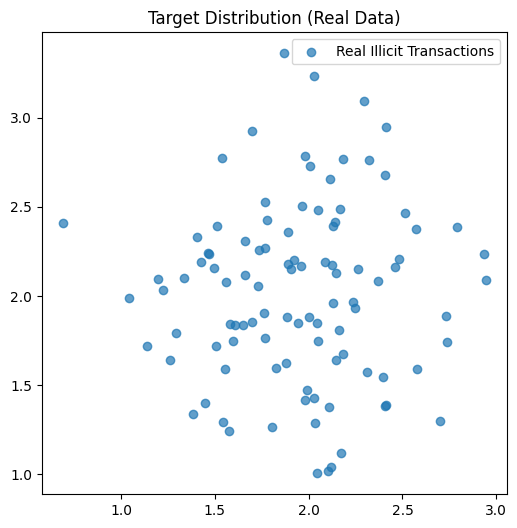

/var/folders/8q/j_629p_55k75hcy496bd95p00000gn/T/ipykernel_50999/375338490.py:73: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits, reps=num_layers, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Quantum Generator Circuit Created.
     ┌─────────────────┐┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ R(noise[0],π/2) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├─────────────────┤├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ R(noise[0],π/2) ├┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └─────────────────┘└──────────┘└───┘└──────────┘└───┘└──────────┘

Starting QGAN Training...
Epoch 0: Loss D=1.4655, Loss G=0.7895
Epoch 50: Loss D=0.7158, Loss G=1.6814
Epoch 100: Loss D=1.5493, Loss G=0.7561
Epoch 150: Loss D=1.2103, Loss G=0.9020
Epoch 200: Loss D=1.4278, Loss G=0.7641
Epoch 250: Loss D=1.4174, Loss G=0.5422


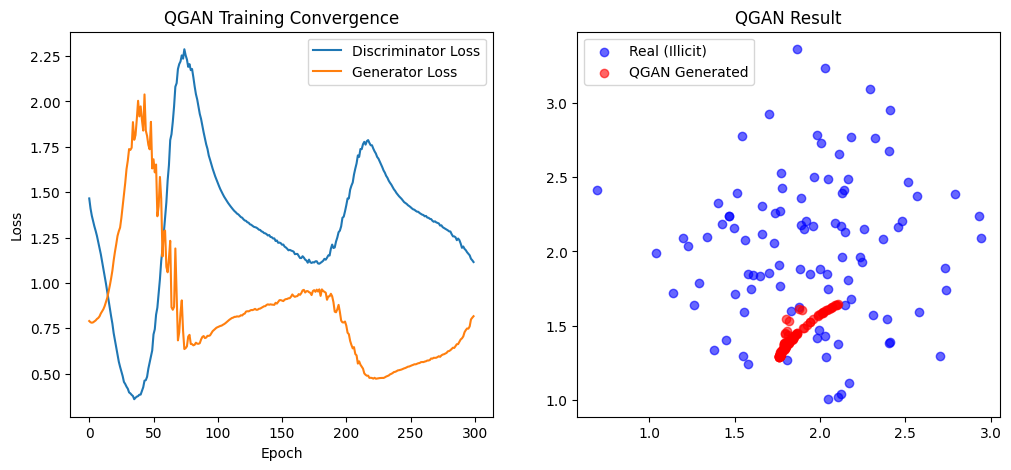

QGAN training complete.


In [ ]:
# ==========================================
# Project: Quantum AML Detection
# Module: Hybrid Quantum GAN for Data Augmentation
# Status: FIXED (Compatible with Qiskit 1.0+ & Input Dimension Fix)
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector # 關鍵修正：引入參數向量
from qiskit.circuit.library import RealAmplitudes

# --- [FIX] Qiskit 1.0+ Primitives Import ---
try:
    from qiskit.primitives import StatevectorSampler as Sampler
    print("Using Qiskit 1.0+ Primitives (StatevectorSampler)")
except ImportError:
    from qiskit.primitives import Sampler
    print("Using Legacy Qiskit Primitives")
# -------------------------------------------

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# 設定隨機種子
torch.manual_seed(42)
np.random.seed(42)

print("Libraries loaded. Initializing Hybrid QGAN environment...")

# ==========================================
# 1. 準備模擬資料 (Simulating Illicit Transaction Features)
# ==========================================
N_SAMPLES = 100
REAL_DATA_MEAN = [2.0, 2.0]
REAL_DATA_STD = [0.5, 0.5]

# 生成真實的"非法"樣本
real_data = torch.tensor(np.random.normal(REAL_DATA_MEAN, REAL_DATA_STD, (N_SAMPLES, 2)), dtype=torch.float32)

# 視覺化真實資料分佈
plt.figure(figsize=(6,6))
plt.scatter(real_data[:,0], real_data[:,1], alpha=0.7, label='Real Illicit Transactions')
plt.title("Target Distribution (Real Data)")
plt.legend()
plt.show()

# ==========================================
# 2. 定義量子生成器 (Quantum Generator) [關鍵修正區塊]
# ==========================================
num_qubits = 2  
num_layers = 2  

# --- [FIX HERE] 定義輸入參數 ---
# 我們需要告訴電路："等一下會有 1 個數值的雜訊傳進來"
# 如果沒有這行，QNN 就會預期輸入維度是 0，導致報錯
input_params = ParameterVector('noise', 1)

# 定義量子電路
qc = QuantumCircuit(num_qubits)

# --- [FIX HERE] 資料編碼 (Data Encoding) ---
# 將輸入的雜訊編碼到量子態中 (使用 Ry 旋轉閘)
for i in range(num_qubits):
    qc.ry(input_params[0], i)

# 加入可訓練的參數化層 (Ansatz)
ansatz = RealAmplitudes(num_qubits, reps=num_layers, entanglement='linear')
qc.compose(ansatz, inplace=True)

print("Quantum Generator Circuit Created.")

# Qiskit 1.0+ 的 draw 可能需要 output='text' 才能正確顯示
print(qc.decompose().draw(output='text'))

# 建立 QNN
def create_generator_qnn(n_qubits):
    # 初始化 Sampler
    sampler = Sampler()
    
    qnn = SamplerQNN(
        circuit=qc,
        # --- [FIX HERE] 將參數註冊到 QNN ---
        input_params=input_params,     # 這裡是輸入 (Noise)
        weight_params=ansatz.parameters, # 這裡是權重 (Weights)
        input_gradients=True,
        sampler=sampler
    )
    return qnn

qnn = create_generator_qnn(num_qubits)

# 將 Qiskit QNN 包裝成 PyTorch Module
class QuantumGenerator(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.qnn = TorchConnector(qnn)
        # 輸出維度轉換: 2^2 (4種機率) -> 2維特徵
        self.linear = nn.Linear(2**num_qubits, 2) 

    def forward(self, x):
        # x 的形狀是 [Batch_Size, 1]
        q_out = self.qnn(x) 
        return self.linear(q_out)

generator = QuantumGenerator(qnn)

# ==========================================
# 3. 定義傳統判別器 (Classical Discriminator)
# ==========================================
class ClassicalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),      
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),       
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = ClassicalDiscriminator()

# ==========================================
# 4. 定義損失函數與最佳化函數
# ==========================================
criterion = nn.BCELoss() 
opt_d = optim.Adam(discriminator.parameters(), lr=0.01)
opt_g = optim.Adam(generator.parameters(), lr=0.01)

# ==========================================
# 5. 訓練迴圈 (Training Loop)
# ==========================================
print("\nStarting QGAN Training...")
epochs = 300 # 示範用 300 輪
loss_d_history = []
loss_g_history = []

for epoch in range(epochs):
    # --- 訓練判別器 ---
    opt_d.zero_grad()
    
    # 真實資料標籤 = 1
    real_labels = torch.ones(N_SAMPLES, 1)
    # 假資料標籤 = 0
    fake_labels = torch.zeros(N_SAMPLES, 1)
    
    # 判別真實資料
    output_real = discriminator(real_data)
    loss_real = criterion(output_real, real_labels)
    
    # 生成假資料 (輸入隨機雜訊，形狀為 [N, 1])
    # 這裡現在可以正常運作了，因為 QNN 已經知道要接收 1 個輸入參數
    noise = torch.randn(N_SAMPLES, 1)
    fake_data = generator(noise) 
    
    # 判別假資料 (detach 防止更新 generator)
    output_fake = discriminator(fake_data.detach()) 
    loss_fake = criterion(output_fake, fake_labels)
    
    loss_d = loss_real + loss_fake
    loss_d.backward()
    opt_d.step()

    # --- 訓練生成器 ---
    opt_g.zero_grad()
    
    # 重新生成假資料 (保留梯度)
    noise = torch.randn(N_SAMPLES, 1)
    fake_data_g = generator(noise)
    output_fake_g = discriminator(fake_data_g)
    
    # 生成器的目標：騙過判別器 (讓判別器覺得是 1)
    loss_g = criterion(output_fake_g, real_labels)
    loss_g.backward()
    opt_g.step()
    
    loss_d_history.append(loss_d.item())
    loss_g_history.append(loss_g.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss D={loss_d.item():.4f}, Loss G={loss_g.item():.4f}")

# ==========================================
# 6. 結果視覺化
# ==========================================
plt.figure(figsize=(12, 5))

# 損失曲線
plt.subplot(1, 2, 1)
plt.plot(loss_d_history, label='Discriminator Loss')
plt.plot(loss_g_history, label='Generator Loss')
plt.title("QGAN Training Convergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 散佈圖
plt.subplot(1, 2, 2)
with torch.no_grad():
    # 使用訓練好的生成器產生資料
    test_noise = torch.randn(100, 1)
    generated_data = generator(test_noise).numpy()

plt.scatter(real_data[:,0], real_data[:,1], alpha=0.6, label='Real (Illicit)', c='blue')
plt.scatter(generated_data[:,0], generated_data[:,1], alpha=0.6, label='QGAN Generated', c='red')
plt.title("QGAN Result")
plt.legend()
plt.show()

print("QGAN training complete.")